In [18]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import matplotlib.pyplot as plt



In [ ]:
# Step 1: Load the training data
with open('/kaggle/input/cuisine/train.json', 'r') as f:
    data = json.load(f)

# Extract features and labels


In [20]:
ids = []
ingredients_list = []
cuisines = []
for recipe in data:
    ids.append(recipe['id'])
    ingredients_list.append(" ".join(recipe['ingredients']))
    cuisines.append(recipe['cuisine'])

In [21]:
# Step 2: Augment Data (Optional)
def augment_data(ingredients):
    ingredients = ingredients.split()
    n = len(ingredients)
    random.shuffle(ingredients)
    return " ".join(ingredients[: random.randint(n // 2, n)])

In [22]:
# Create augmented data
train_data_augmented = pd.DataFrame({"ingredients": ingredients_list, "cuisine": cuisines})
train_data_augmented["ingredients"] = train_data_augmented["ingredients"].apply(augment_data)
augmented_ingredients_list = train_data_augmented["ingredients"].tolist()
augmented_cuisines = train_data_augmented["cuisine"].tolist()

# Combine original and augmented data
combined_ingredients = ingredients_list + augmented_ingredients_list
combined_cuisines = cuisines + augmented_cuisines

In [23]:
# Step 3: Encode ingredients and cuisines
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")  # Use TF-IDF
X_combined = vectorizer.fit_transform(combined_ingredients).toarray()

label_encoder = LabelEncoder()  # Encode cuisine labels
y_combined = label_encoder.fit_transform(combined_cuisines)

In [24]:
# Split the combined data back into original and augmented
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


In [25]:

# Step 4: Create PyTorch Dataset and DataLoader
class CuisineDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [26]:

train_dataset = CuisineDataset(X_train_tensor, y_train_tensor)
val_dataset = CuisineDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [27]:

# Step 5: Define the Neural Network
class CuisineNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CuisineNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)
        
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu3(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [28]:
input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = CuisineNet(input_size, num_classes)

# Step 6: Define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [29]:
# Step 7: Training Loop with Early Stopping
best_val_accuracy = 0
patience = 5
trigger_times = 0

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = correct / total
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")
     # Validation Step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}")

    # Early Stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()


Epoch 1/20
Train Loss: 1.3175, Accuracy: 0.6335
Validation Loss: 0.8996, Accuracy: 0.7309
Epoch 2/20
Train Loss: 0.8623, Accuracy: 0.7330
Validation Loss: 0.7967, Accuracy: 0.7565
Epoch 3/20
Train Loss: 0.6733, Accuracy: 0.7728
Validation Loss: 0.7433, Accuracy: 0.7736
Epoch 4/20
Train Loss: 0.5606, Accuracy: 0.7991
Validation Loss: 0.7047, Accuracy: 0.7886
Epoch 5/20
Train Loss: 0.4784, Accuracy: 0.8176
Validation Loss: 0.6655, Accuracy: 0.7941
Epoch 6/20
Train Loss: 0.3440, Accuracy: 0.8567
Validation Loss: 0.6217, Accuracy: 0.8263
Epoch 7/20
Train Loss: 0.2805, Accuracy: 0.8763
Validation Loss: 0.6593, Accuracy: 0.8333
Epoch 8/20
Train Loss: 0.2462, Accuracy: 0.8879
Validation Loss: 0.6297, Accuracy: 0.8357
Epoch 9/20
Train Loss: 0.2223, Accuracy: 0.8955
Validation Loss: 0.6539, Accuracy: 0.8440
Epoch 10/20
Train Loss: 0.2015, Accuracy: 0.9046
Validation Loss: 0.6436, Accuracy: 0.8479
Epoch 11/20
Train Loss: 0.1590, Accuracy: 0.9201
Validation Loss: 0.6337, Accuracy: 0.8579
Epoch 12

<Figure size 1200x1200 with 0 Axes>

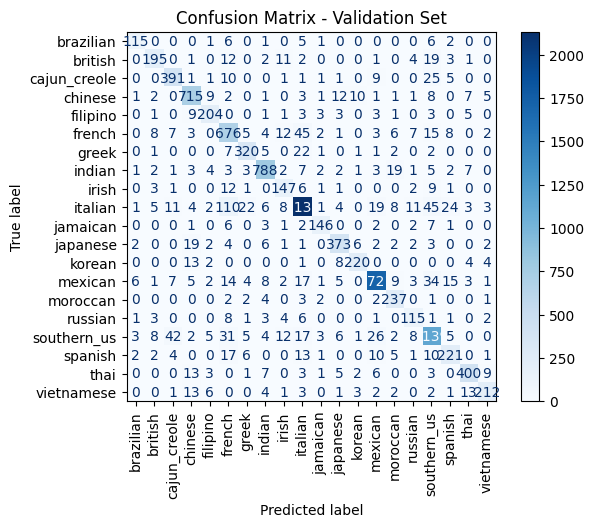

In [30]:

# Step 8: Confusion Matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for features, labels in val_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = outputs.max(1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [31]:


# Step 9: Load Test Data
with open('/kaggle/input/cuisine/test.json', 'r') as f:
    test_data = json.load(f)

test_ids = []
test_ingredients = []
for recipe in test_data:
    test_ids.append(recipe['id'])
    test_ingredients.append(" ".join(recipe['ingredients']))

# Transform test data
X_test = vectorizer.transform(test_ingredients).toarray()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Step 10: Make Predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = outputs.max(1)
    predicted_labels = label_encoder.inverse_transform(predicted.cpu().numpy())

# Step 11: Prepare Submission File
submission = pd.DataFrame({'Id': test_ids, 'Category': predicted_labels})
submission.sort_values('Id', inplace=True)
submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


In [32]:
TP = np.diag(conf_matrix)  # True Positives for each class
FP = conf_matrix.sum(axis=0) - TP  # False Positives for each class
FN = conf_matrix.sum(axis=1) - TP  # False Negatives for each class
TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives for each class

# Overall Accuracy calculation
accuracy = np.sum(TP) / np.sum(conf_matrix)
print("Tp",len(TP))
print("TN",TN)
print("FN",FN)
print("FP",FP)
print(f"Validation Set Accuracy: {accuracy:.4f}")

Tp 20
TN [11756 11623 11390 11044 11636 10862 11498 10995 11670  9331 11718 11436
 11634  9961 11599 11722 10393 11549 11414 11616]
FN [ 22  56  55  64  33 128  42  68  37 287  25  52  32 137  17  31 180  72
  53  52]
FP [ 17  36  74  87  37 244  50  59  56 160  21  49  24  91  57  42 198  68
  43  30]
Validation Set Accuracy: 0.8788
